In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.lines import Line2D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
full_dataset = pd.read_csv('/content/drive/MyDrive/Data Projects/Height vs Weather/complete_height_vs_temperature_plus_other_variables_ds.csv')
model_ds = full_dataset.drop_duplicates(subset=['country', 'temp_mean1940_2024'])


In [ ]:
model_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 24791
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  196 non-null    int64  
 1   country                                     196 non-null    object 
 2   AverageHeightBoysAge19                      196 non-null    float64
 3   AverageHeightGirlsAge19                     196 non-null    float64
 4   AvgHgtBoysAge19                             195 non-null    float64
 5   AvgHgtGirlsAge19                            195 non-null    float64
 6   AverageHeightBoysAge15                      196 non-null    float64
 7   AverageHeightGirlsAge15                     196 non-null    float64
 8   AverageHeightBoysAge10                      196 non-null    float64
 9   AverageHeightGirlsAge10                     196 non-null    float64
 10  AverageHeightBoys

In [ ]:
# Start working on backward elimination multilinear model
final_model_data = model_ds[['AvgHgtBoysAge19', 'temp_mean1940_2024', 'winter_temp', 'adm_temp_mean1940_2024',
       'meat_pc_kg1961_2021', 'cereal_per_hectare1961_2022', 'gdp_per_capita1990_2022', 'freedom_expression_index1789_2023',
       'health_expenditure_pc2000_2021', 'women_political_empowerment_index1789_2023', 'population_density_10000BC_2100']].dropna()
final_model_data_not_log = final_model_data
# Log-transform the columns with seemingly non-linear relationship
log_columns = ['cereal_per_hectare1961_2022', 'gdp_per_capita1990_2022', 'health_expenditure_pc2000_2021']

# Apply log transformation and create new columns
for col in log_columns:
    final_model_data[f'log_{col}'] = np.log(final_model_data[col])

# Taking only the logged variables
final_model_data = final_model_data[['AvgHgtBoysAge19', 'temp_mean1940_2024',
       'meat_pc_kg1961_2021', 'log_cereal_per_hectare1961_2022', 'log_gdp_per_capita1990_2022', 'freedom_expression_index1789_2023',
       'log_health_expenditure_pc2000_2021', 'women_political_empowerment_index1789_2023', 'population_density_10000BC_2100']]

final_model_data.info()

final_model_data.to_csv('/content/drive/MyDrive/Data Projects/Height vs Weather/multilinear_XGBoost_model_data.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 0 to 23338
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AvgHgtBoysAge19                             148 non-null    float64
 1   temp_mean1940_2024                          148 non-null    float64
 2   meat_pc_kg1961_2021                         148 non-null    float64
 3   log_cereal_per_hectare1961_2022             148 non-null    float64
 4   log_gdp_per_capita1990_2022                 148 non-null    float64
 5   freedom_expression_index1789_2023           148 non-null    float64
 6   log_health_expenditure_pc2000_2021          148 non-null    float64
 7   women_political_empowerment_index1789_2023  148 non-null    float64
 8   population_density_10000BC_2100             148 non-null    float64
dtypes: float64(9)
memory usage: 11.6 KB


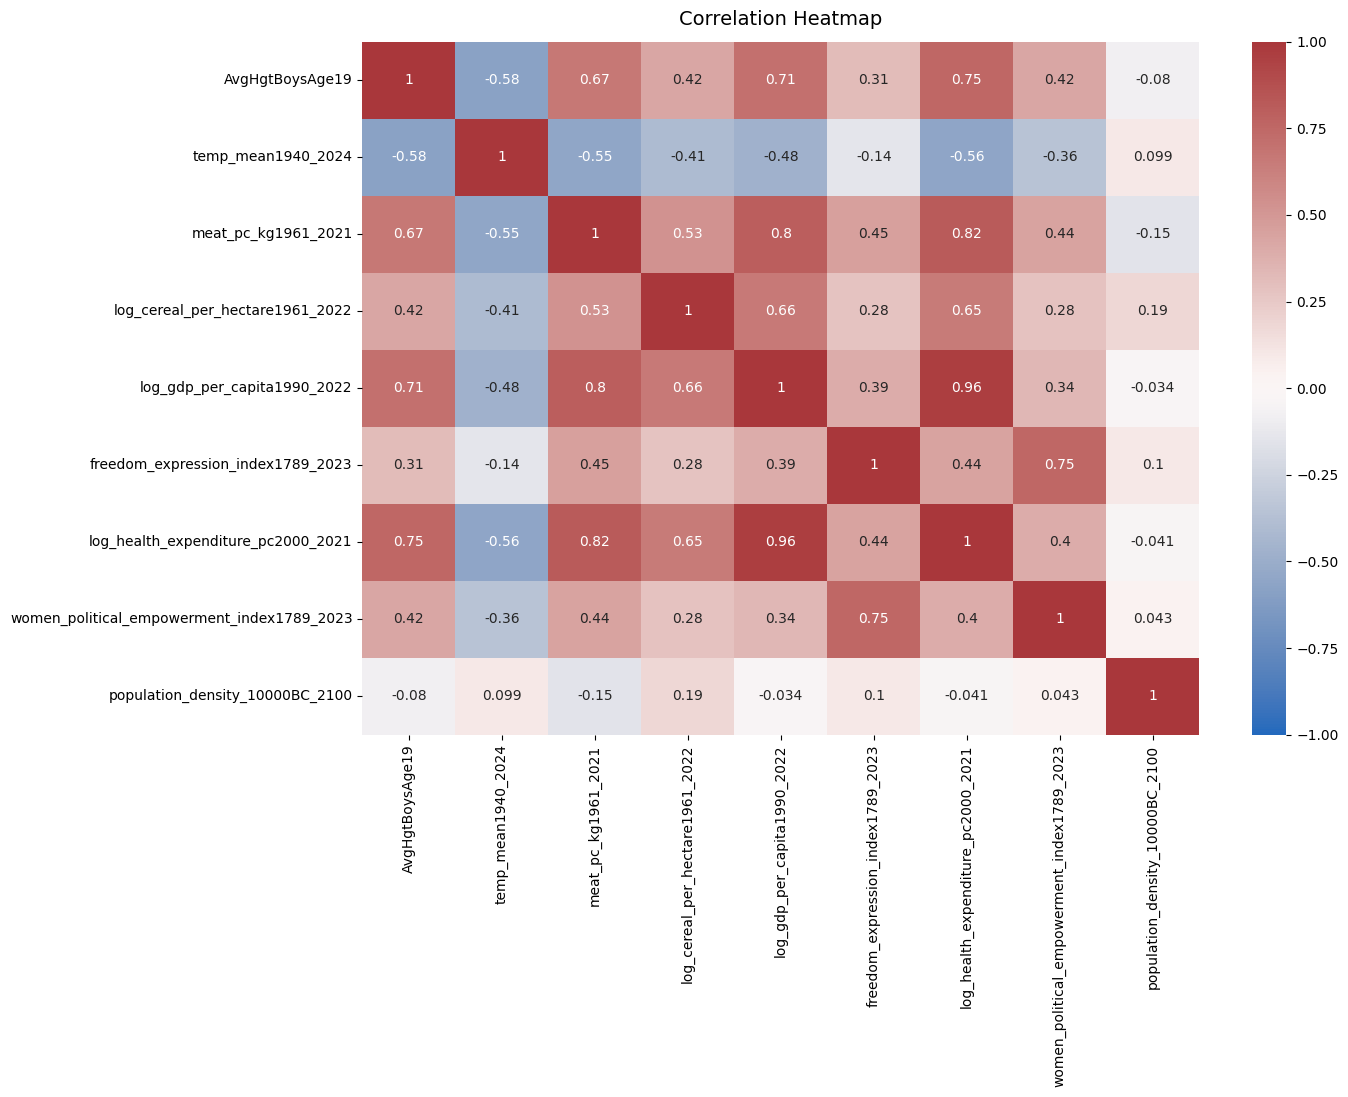

In [ ]:
# Plot a correlation heatmap
plt.figure(figsize=(13.5, 9))
heatmap = sns.heatmap(final_model_data.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [ ]:
# Defining the backward elimination function based on significane level and predictor number
def backward_elimination(X, y, significance_level=0.05, pred_num=None, show_deets = False):
    # Set default value of n to the total number of predictors (excluding the constant)
    if pred_num is None:
        pred_num = X.shape[1]

    while True:
        # Fit the model
        model = sm.OLS(y, X).fit()
        if show_deets is True:
          print(model.pvalues)

        # Get p-values and find the highest one
        max_pval = model.pvalues.max()

        # Remove the predictor with the highest p-value if it exceeds the significance level
        if max_pval > significance_level:
            excluded_feature = model.pvalues.idxmax()
            print(f"Removing '{excluded_feature}' with p-value {max_pval}")
            X = X.drop(columns=[excluded_feature])
        else:
            # If all predictors are significant but their count exceeds n, remove the least significant
          if X.shape[1] > pred_num + 1: # number of predictors without const term
                # Sort predictors by p-value (descending) and drop the least significant
                sorted_pvalues = model.pvalues.sort_values(ascending=False)
                excluded_feature = sorted_pvalues.index[0]
                feature_pval = model.pvalues.max()
                print(f"Removing '{excluded_feature}' with p-value {feature_pval}")
                X = X.drop(columns=[excluded_feature])
          else:
            break

    return model, X

In [ ]:
# Seperating dependent and independent variables
X = final_model_data.drop(columns=['AvgHgtBoysAge19'])  # Independent variables
y = final_model_data['AvgHgtBoysAge19']  # Dependent variable

# Add a constant for the intercept
X = sm.add_constant(X)

# Run the multilinear model and see which variables are significant predictors
final_model, final_X = backward_elimination(X, y, 0.05, 3)

# Display the summary of the final model
final_model.summary()



Removing 'population_density_10000BC_2100' with p-value 0.8519082783816836
Removing 'log_gdp_per_capita1990_2022' with p-value 0.8131291247266211
Removing 'meat_pc_kg1961_2021' with p-value 0.3783047884016989
Removing 'freedom_expression_index1789_2023' with p-value 0.04336772808671103
Removing 'log_cereal_per_hectare1961_2022' with p-value 0.04574576289250221


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        AvgHgtBoysAge19   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     75.96
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.63e-29
Time:                        02:49:49   Log-Likelihood:                -380.31
No. Observations:                 148   AIC:                             768.6
Df Residuals:                     144   BIC:                             780.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                        159.9132      2.036     78.526      0.000     155.888     163.938
temp_mean1940_2024                            -0.1319      0.039     -3.364      0.001      -0.209      -0.054
log_health_expenditure_pc2000_2021             2.2343      0.248      9.021      0.000       1.745       2.724
women_political_empowerment_index1789_2023     3.6909      1.861      1.983      0.049       0.012       7.370
==============================================================================
Omnibus:                        3.650   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.727
Skew:                           0.189   Prob(JB):                        0.256
Kurtosis:                       2.453   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

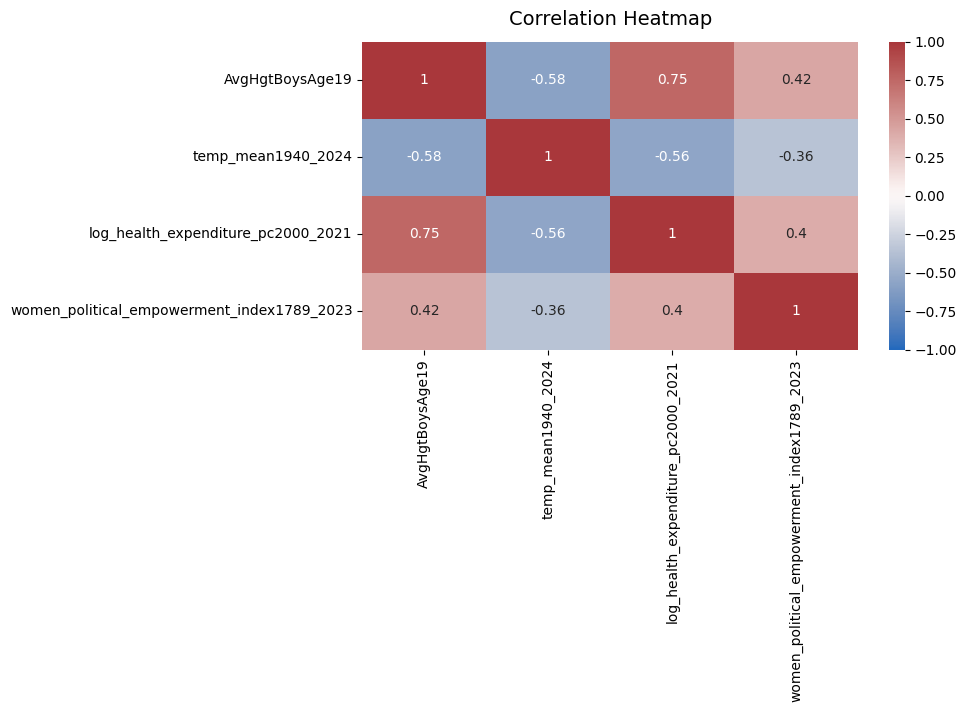

In [ ]:
only_predictors_ds = final_model_data[['AvgHgtBoysAge19', 'temp_mean1940_2024', 'log_health_expenditure_pc2000_2021', 'women_political_empowerment_index1789_2023']]

# Plot a correlation heatmap
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(only_predictors_ds.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [ ]:
# next create residuals of model temp~health and women_empowerment~health and use the residuals to create a model instead of the values itself first make sure thats not what the existing linear model is doing.

In [ ]:
# Running a linear regression model to check the strength and significance of the correlation (Height~Healthcare Expenditure) simple linear model

X_male = final_model_data_not_log['health_expenditure_pc2000_2021']
Y = final_model_data_not_log['AvgHgtBoysAge19']

X_male_const = sm.add_constant(X_male)

model_health = sm.OLS(Y, X_male_const).fit()

model_health.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        AvgHgtBoysAge19   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     103.5
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.04e-18
Time:                        02:50:08   Log-Likelihood:                -410.86
No. Observations:                 148   AIC:                             825.7
Df Residuals:                     146   BIC:                             831.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            170.3415      0.415    410.032      0.000     169.520     171.163
health_expenditure_pc2000_2021     0.0024      0.000     10.174      0.000       0.002       0.003
==============================================================================
Omnibus:                        3.755   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.710
Skew:                           0.344   Prob(JB):                        0.156
Kurtosis:                       2.643   Cond. No.                     2.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Running a linear regression model to check the strength and significance of the correlation (Height~log(Healthcare Expenditure)) simple linear model

X_male = final_model_data['log_health_expenditure_pc2000_2021']
Y = final_model_data['AvgHgtBoysAge19']

X_male_const = sm.add_constant(X_male)

model_health = sm.OLS(Y, X_male_const).fit()

model_health.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        AvgHgtBoysAge19   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     188.9
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           4.15e-28
Time:                        02:50:18   Log-Likelihood:                -389.08
No. Observations:                 148   AIC:                             782.2
Df Residuals:                     146   BIC:                             788.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                155.1357      1.330    116.620      0.000     152.507     157.765
log_health_expenditure_pc2000_2021     2.8671      0.209     13.745      0.000       2.455       3.279
==============================================================================
Omnibus:                        1.553   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.447
Skew:                           0.126   Prob(JB):                        0.485
Kurtosis:                       2.587   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Importing necessary libarires for creating XGBoosting predictor model
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# This module lets us save our models once we fit them.
import pickle

In [ ]:
XGBoost_model_ds = model_ds[['AvgHgtBoysAge19', 'temp_mean1940_2024', 'winter_temp', 'adm_temp_mean1940_2024',
       'meat_pc_kg1961_2021', 'cereal_per_hectare1961_2022', 'gdp_per_capita1990_2022', 'freedom_expression_index1789_2023',
       'health_expenditure_pc2000_2021', 'women_political_empowerment_index1789_2023', 'population_density_10000BC_2100']].dropna()


# Data preparation
X = final_model_data.drop(columns=['AvgHgtBoysAge19'])  # Independent variables
y = final_model_data['AvgHgtBoysAge19']  # Dependent variable (target)

Mean Squared Error (MSE): 8.220850200165312
R-squared (R2): 0.681310462584544


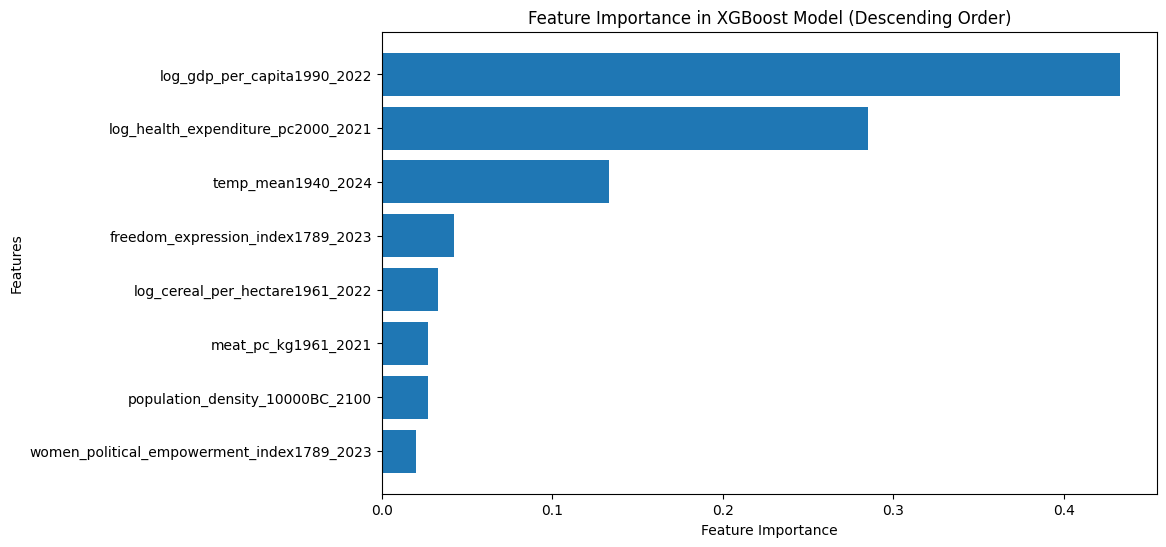

In [ ]:
# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=100,     # Number of trees
    learning_rate=0.01,    # Step size shrinkage
    max_depth=3,          # Maximum depth of trees
    random_state=42,      # Ensures reproducibility
)

# Train the model
xgb_model.fit(X, y)

# Predict on the test set
y_pred = xgb_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Extract feature importances and sort them in descending order
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Indices of sorted importance in descending order

# Sort features and their importance
sorted_features = X.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance)
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model (Descending Order)")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_check_data = model_ds[['AvgHgtBoysAge19', 'temp_mean1940_2024',
       'meat_pc_kg1961_2021', 'cereal_per_hectare1961_2022', 'freedom_expression_index1789_2023',
       'health_expenditure_pc2000_2021', 'women_political_empowerment_index1789_2023', 'population_density_10000BC_2100']].dropna()


# Data preparation
X = vif_check_data.drop(columns=['AvgHgtBoysAge19'])  # Independent variables
y = vif_check_data['AvgHgtBoysAge19']  # Dependent variable (target)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                      Feature        VIF
0                          temp_mean1940_2024   4.423266
1                         meat_pc_kg1961_2021   7.880280
2                 cereal_per_hectare1961_2022   5.703003
3           freedom_expression_index1789_2023  13.498062
4              health_expenditure_pc2000_2021   6.555146
5  women_political_empowerment_index1789_2023  13.971522
6             population_density_10000BC_2100   2.007091


In [ ]:
from sklearn.decomposition import PCA

# Data preparation
X = vif_check_data.drop(columns=['AvgHgtBoysAge19'])  # Independent variables
y = vif_check_data['AvgHgtBoysAge19']  # Dependent variable (target)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Check explained variance
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Use transformed components in regression


Explained Variance Ratio: [9.95973170e-01 3.85694581e-03 1.44717632e-04 2.41520822e-05
 9.90074328e-07 2.09980031e-08 3.42757262e-09]


In [ ]:
from sklearn.linear_model import Lasso, Ridge

# Data preparation
X = final_model_data.drop(columns=['AvgHgtBoysAge19'])  # Independent variables
y = final_model_data['AvgHgtBoysAge19']  # Dependent variable (target)

# Lasso Regression
lasso = Lasso(alpha=0.01)  # Adjust alpha for regularization strength
lasso.fit(X, y)
y_pred_lasso = lasso.predict(X)
print(f"Lasso R^2: {r2_score(y, y_pred_lasso)}")
print(f"Lasso Coefficients: {lasso.coef_}")

# Ridge Regression
ridge = Ridge(alpha=0.01)
ridge.fit(X, y)
y_pred_ridge = ridge.predict(X)
print(f"Ridge R^2: {r2_score(y, y_pred_ridge)}")
print(f"Ridge Coefficients: {ridge.coef_}")


Lasso R^2: 0.6351840810955529
Lasso Coefficients: [-1.13980121e-01  1.51527212e-02 -1.01649158e+00  2.17350332e-01
 -3.07196563e+00  2.29763620e+00  6.08398495e+00  3.87409224e-04]
Ridge R^2: 0.636428173856473
Ridge Coefficients: [-1.03022915e-01  1.51958110e-02 -1.08646495e+00  2.22056205e-01
 -4.32415893e+00  2.36877396e+00  7.77610460e+00  6.14845943e-04]


In [ ]:
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway

def fit_model_with_significant_predictors(X, y, significance_level=0.05):
    """
    Fits an OLS model and iteratively removes predictors with p-values >= significance_level.
    """
    while True:
        model = sm.OLS(y, X).fit()
        # Get the predictor with the highest p-value
        max_pval = model.pvalues.max()
        if max_pval > significance_level:
            # Remove the predictor with the highest p-value
            excluded_feature = model.pvalues.idxmax()
            if excluded_feature == 'const':
                break  # Avoid removing the constant
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return model, X


# Define predictors and target
X_no_temp = final_model_data.drop(columns=['temp_mean1940_2024', 'AvgHgtBoysAge19'])  # Exclude temperature
X_with_temp = final_model_data.drop(columns=['AvgHgtBoysAge19'])  # Include temperature
y = final_model_data['AvgHgtBoysAge19']  # Target variable

# Add constant to predictors
X_no_temp = sm.add_constant(X_no_temp)
X_with_temp = sm.add_constant(X_with_temp)

# Fit models with only significant predictors
model_no_temp, X_no_temp_significant = fit_model_with_significant_predictors(X_no_temp, y)
model_with_temp, X_with_temp_significant = fit_model_with_significant_predictors(X_with_temp, y)

# # Add constant to predictors for OLS regression
# X_no_temp = sm.add_constant(X_no_temp)
# X_with_temp = sm.add_constant(X_with_temp)

# # Fit the models using OLS
# model_no_temp = sm.OLS(y, X_no_temp).fit()  # Model without temperature
# model_with_temp = sm.OLS(y, X_with_temp).fit()  # Model with temperature

# Perform ANOVA to compare the two models
anova_results = anova_lm(model_no_temp, model_with_temp)

# Print ANOVA results
print(anova_results)


   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0     144.0  1497.888612      0.0         NaN       NaN       NaN
1     142.0  1396.628039      2.0  101.260573  5.147756  0.006945
